In [16]:
import dimod
import dwave
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite
from dwave.embedding.pegasus import find_clique_embedding

import dwave_networkx as dnx
import networkx as nx
import minorminer

import numpy as np
from matplotlib import pyplot as plt
from tqdm import notebook

import pickle

from OptimizeChainStrength import det_chain_strength

In [21]:
def annealing(H,num_shot,sampler=None,embedding=None,anneal_time=None,chain_strength=10):
    if type(sampler) == None or type(embedding) == None:
        sampler_  = SimulatedAnnealingSampler()
        sampleset = sampler_.sample(H,num_reads=num_shot,answer_mode='raw')
    else:
        sampler_     = FixedEmbeddingComposite(sampler,embedding)
        sampleset    = sampler_.sample(H,num_reads=num_shot,chain_strength=chain_strength,\
                                    answer_mode='raw',annealing_time=anneal_time)
    return sampleset

def hamiltonianJ1J2(L,J1=1.0,J2=1.0,PBC=True):
    L2        = L**2
    linear    = {}
    quadratic = {}
    for i in np.arange(1,L**2,L):
        if PBC == True:
    #        J1 수평
            quadratic[(i,i+L-1)] = -J1
        for j in np.arange(L-1):
    #       J1 수평
            quadratic[(i+j,i+j+1)] = -J1
            if i < L*(L-1):
    #          J2 오른쪽 밑
                quadratic[(i+j,i+j+L+1)] = J2
    #    J2
        if PBC == True:
            if i < L * (L-1):
                quadratic[(i+L-1,i+L)]       = J2
                i_ = i // L + 1 
                quadratic[(i_+L*(L-1),i_+1)] = J2
    for i in np.arange(1,L+1):
        if PBC == True:
    #        J1 수직
            quadratic[(i,i+L*(L-1))] = -J1
        for j in np.arange(L-1):
    #        J1 수직
            quadratic[(i+j*L,i+(j+1)*L)] = -J1
            if i < L:
    #            J2 왼쪽 밑
                quadratic[(i+j*L+1,i+(j+1)*L)] = J2
        if PBC == True:
            if i < L:
    #             J2
                quadratic[(L*(i-1)+1,L*(i+1))] = J2
                quadratic[(L*(L-1)+i+1,i)]     = J2
    # J2
    if PBC == True:
        quadratic[(1,L**2)]      = J2
        quadratic[(L*(L-1)+1,L)] = J2
    H = dimod.BinaryQuadraticModel(linear,quadratic,0,vartype='SPIN')
    return H  

def get_confi(confi,embedding):
    qubit_lst = list(embedding.keys())
    confi_ = {}
    for qubit in qubit_lst:
        chains = embedding[qubit]
        chain_confi = np.array([confi[chain] for chain in chains])
        spin = np.random.choice(chain_confi)
        confi_[qubit] = spin
    return confi_

def check_chain_break(confi,embedding):
    for chains in embedding.values():
        lst = []
        for chain in chains:
            lst.append(confi[chain])
        if np.abs(np.mean(lst)) != 1:
            return True
    return False

def find_embedding(source,target,initial=None):
    if type(initial) != type(None):
        embedding = minorminer.find_embedding(source.edges(),target.edges(),initial_chains=initial)
    else:
        embedding = minorminer.find_embedding(source.edges(),target.edges())
    return embedding

def ret_num_chain(embedding):
    cnt = 0
    for val in embedding.values():
        cnt += len(val) - 1
    return cnt

def defaultJc(H,prefactor=1.414):
    num_interactions = H.num_interactions
    quadratic_array = np.fromiter(H.quadratic.values(), dtype=float, count=num_interactions)    
    squared_j = quadratic_array**2
    rms = np.sqrt(squared_j.sum() / num_interactions)
    avg_degree = H.degrees(array=True).mean()
    Jc = prefactor * rms * np.sqrt(avg_degree)   
    return Jc

In [12]:
sampler            = DWaveSampler(solver='Advantage_system6.3',\
                                  token='----')
print("Connected to sampler", sampler.solver.name)
pegasus_properties = sampler.properties
pegasus_graph      = sampler.to_networkx_graph()

Connected to sampler Advantage_system6.3


In [13]:
L        = 8
J1       = 10
J2       = 4
num_shot = 1000
H        = hamiltonianJ1J2(L,J1,J2)
G        = dimod.to_networkx_graph(H)

In [15]:
embd_num      = 500
embd_lst      = []
chain_num_lst = []

for _ in notebook.tqdm(np.arange(embd_num)):
    embd      = find_embedding(G,pegasus_graph)
    chain_num = ret_num_chain(embd)
    embd_lst.append(embd)
    chain_num_lst.append(chain_num)

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
idx        = np.argmin(chain_num_lst)
embedding  = embd_lst[idx]
embedding_ = {}
for qubit, chains in embedding.items():
    for chain in chains:
        embedding_[chain] = (chain,)

In [18]:
embedding

{1: [1981, 3205, 1982],
 8: [2011, 3176],
 2: [3280],
 10: [1997],
 16: [2147, 2146, 3311, 3206],
 9: [2012, 3445],
 57: [3175, 1951],
 58: [1966],
 64: [3115, 1890],
 7: [3161, 2055],
 15: [3281, 2116, 2207],
 63: [3146, 3145, 2040],
 3: [3295],
 11: [3370, 2027],
 59: [3250, 1891],
 18: [3430, 1967],
 19: [3385, 2117],
 17: [3400, 3401, 2087],
 4: [2056],
 12: [2041, 3356],
 60: [3265, 1906],
 20: [2102],
 5: [2086, 3220, 3266],
 13: [3341],
 61: [3234, 3235],
 21: [2132, 3431],
 6: [2070, 2071],
 14: [3326, 2131, 2162],
 62: [3131, 2026, 3130],
 22: [2177, 2178],
 23: [2072, 3446],
 24: [3415, 2057, 3416],
 50: [3309, 1921, 3310],
 56: [3114, 1875],
 49: [3160, 3159],
 26: [3490, 1983, 1952],
 27: [3476, 3475],
 25: [3564, 3565, 1968],
 28: [3461, 3460],
 29: [3505, 3506, 1998],
 30: [3520, 1907, 3521, 2133],
 31: [1833, 3535, 3536],
 32: [3549, 3550],
 51: [3324, 3325],
 34: [1848, 3474],
 35: [3414, 1892, 1772],
 33: [3489, 1803],
 36: [1937, 3355],
 37: [1922, 3399],
 38: [1877, 

In [84]:
num_shot      = 1000
anneal_time   = 700
sampleset_lst = []
J2_lst        = np.array([3.8,4.0,4.2,4.4,4.6,4.8])
J2num         = J2_lst.shape[0]
for i in notebook.tqdm(np.arange(J2num)):
    J2            = J2_lst[i]
    H             = hamiltonianJ1J2(L,J1,J2) 
    Jc            = defaultJc(H)
    H_            = dwave.embedding.embed_bqm(H,embedding,pegasus_graph,chain_strength=Jc) 
    sampleset     = annealing(H_,num_shot,sampler,embedding_,anneal_time)    
    sampleset_lst.append(sampleset)

  0%|          | 0/6 [00:00<?, ?it/s]

In [85]:
sampleset_lst_default = sampleset_lst

In [26]:
num_shot      = 100
anneal_time   = 1000
Sampleset_lst = []
J2_lst        = np.array([3.8,4.0,4.2,4.4,4.6,4.8])
J2num         = J2_lst.shape[0]
Jc_lst        = []
num           = 10
for i in notebook.tqdm(np.arange(J2num)):
    sampleset_lst = []
    J2            = J2_lst[i]
    H             = hamiltonianJ1J2(L,J1,J2) 
    init_Jc       = defaultJc(H)
    init_Jc_lst   = np.linspace(init_Jc/10,init_Jc,num=num)
    for j in np.arange(num):
        Jc        = init_Jc_lst[j]
        H_        = dwave.embedding.embed_bqm(H,embedding,pegasus_graph,chain_strength=Jc) 
        sampleset = annealing(H_,num_shot,sampler,embedding_,anneal_time)
        sampleset_lst.append(sampleset)
        confi     = sampleset.first.sample
        if check_chain_break(confi,embedding) == False:
            if j == 0:
                Jc_ = init_Jc_lst[0]
            else:
                Jc_ = init_Jc_lst[j-1]
            Jc_lst.append(Jc_)
            break     
    Sampleset_lst.append(sampleset_lst)

  0%|          | 0/6 [00:00<?, ?it/s]

In [28]:
Sampleset_lst_test = Sampleset_lst

In [27]:
Jc_lst

[6.050598360360734,
 6.091698429830552,
 9.201913950825663,
 9.268939872585214,
 9.338568143436122,
 12.5476546676102]

In [77]:
num_shot      = 1000
anneal_time   = 700
cnst          = 1.8
sampleset_lst = []
for i in notebook.tqdm(np.arange(J2num)):
    J2 = J2_lst[i]
    H  = hamiltonianJ1J2(L,J1,J2) 
    Jc = cnst * Jc_lst[i]
    H_ = dwave.embedding.embed_bqm(H,embedding,pegasus_graph,chain_strength=Jc) 
    sampleset = annealing(H_,num_shot,sampler,embedding_,anneal_time)
    sampleset_lst.append(sampleset)    

  0%|          | 0/6 [00:00<?, ?it/s]

In [78]:
# default, 1, 1_4, 1_6, 1_8
sampleset_lst1_8 = sampleset_lst

In [86]:
ener_lst      = []
sampleset_lst = sampleset_lst_default
for i in notebook.tqdm(np.arange(J2num)):
    J2        = J2_lst[i]
    H         = hamiltonianJ1J2(L,J1,J2) 
    sampleset = sampleset_lst[i]
    confi     = sampleset.first.sample
    E         = 0
    if check_chain_break(confi,embedding) == False:
        cnt = 0
        for sample in sampleset.samples():
            if check_chain_break(sample,embedding) == False:
                sample_ = get_confi(sample,embedding)
                E      += H.energy(sample_)
                cnt    += 1
    E /= cnt
    ener_lst.append(E)
ener_lst = np.array(ener_lst)

  0%|          | 0/6 [00:00<?, ?it/s]

In [87]:
ener_lst_default = ener_lst

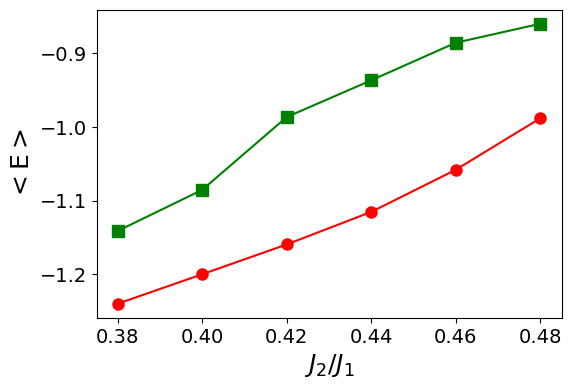

In [90]:
ssize                          = 8
markersize                     = 10
plt.rcParams["font.size"]      = 14
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(J2_lst/J1,ener_lst1_4/(J1*L**2),color='r',marker='o',markersize=ssize)
# plt.plot(J2_lst/J1,ener_lst1_6/(J1*L**2),color='b',marker='^',markersize=ssize)
# plt.plot(J2_lst/J1,ener_lst1_8/(J1*L**2),color='m',marker='d',markersize=ssize)
plt.plot(J2_lst/J1,ener_lst_default/(J1*L**2),color='g',marker='s',markersize=ssize)
plt.xlabel('$J_2/J_1$',fontsize=18)
plt.ylabel('$<\\text{E}>$',fontsize=18)
plt.show()